In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory
from importlib import reload
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events
from flovopy.core.mvo import dome_location, REGION_DEFAULT
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig
# -------------------------- Config --------------------------
# directories
HOME = Path.home()
PROJECTDIR      = HOME / "Dropbox" / "BRIEFCASE" / "SSADenver"
LOCALPROJECTDIR = HOME / "work" / "PROJECTS" / "SSADenver_local"
OUTPUT_DIR      = LOCALPROJECTDIR / "asl_results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
INPUT_DIR       = PROJECTDIR / "ASL_inputs" / "biggest_pdc_events"
GLOBAL_CACHE    = PROJECTDIR / "asl_global_cache"
METADATA_DIR    = PROJECTDIR / "metadata" 
STATION_CORRECTIONS_DIR = PROJECTDIR / "station_correction_analysis"

# master files
INVENTORY_XML   = METADATA_DIR / "MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = METADATA_DIR / "MONTSERRAT_DEM_WGS84_MASTER.tif"
GRIDFILE_DEFAULT= METADATA_DIR / "MASTER_GRID_MONTSERRAT.pkl"

# parameters for envelopes and cross-correlation
SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5

# other parameters
DIST_MODE = "3d" # or 2d. will essentially squash Montserrat topography and stations onto a sea-level plane, ignored elevation data, e.g. for computing distances

# Inventory of Montserrat stations
from obspy import read_inventory
INV     = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

# Montserrat station corrections estimated from regionals
station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals.csv"
annual_station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals_by_year.csv"
station_corrections_df = pd.read_csv(station_corrections_csv)
annual_station_corrections_df = pd.read_csv(annual_station_corrections_csv)

# Montserrat pre-defined Grid (from 02 tutorial)
from flovopy.asl.grid import Grid
gridobj = Grid.load(GRIDFILE_DEFAULT)
print(gridobj)


# Montserrat constants
from flovopy.core.mvo import dome_location, REGION_DEFAULT
print("Dome (assumed source) =", dome_location)

# events and wrappers
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events
event_files = list(find_event_files(INPUT_DIR))
eventcsvfile = Path(OUTPUT_DIR) / "mseed_files.csv"
if not eventcsvfile.is_file():
    rows = [{"num": num, "f": str(f)} for num, f in enumerate(event_files)]
    df = pd.DataFrame(rows)
    df.to_csv(eventcsvfile, index=False)
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]
best_event_files = [event_files[i] for i in best_file_nums]
print(f'Best miniseed files are: {best_event_files}')
REFINE_SECTOR = False   # enable triangular dome-to-sea refinement

# Parameters to pass for making pygmt topo maps
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}

[INV] Networks: 1  Stations: 48  Channels: 77
[INFO] Grid loaded from /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/metadata/MASTER_GRID_MONTSERRAT.pkl
[GRID] 831x1051 nodes (873381 total)  spacing=10.0 m  [mask: 59905/873381 nodes kept (6.9%)]
Dome (assumed source) = {'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}
Best miniseed files are: ['/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-05-1840-17S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-07-0441-43S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-09-14-1900-58S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-11-26-2123-08S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-04-12-0025-40S.MVO___031.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/A

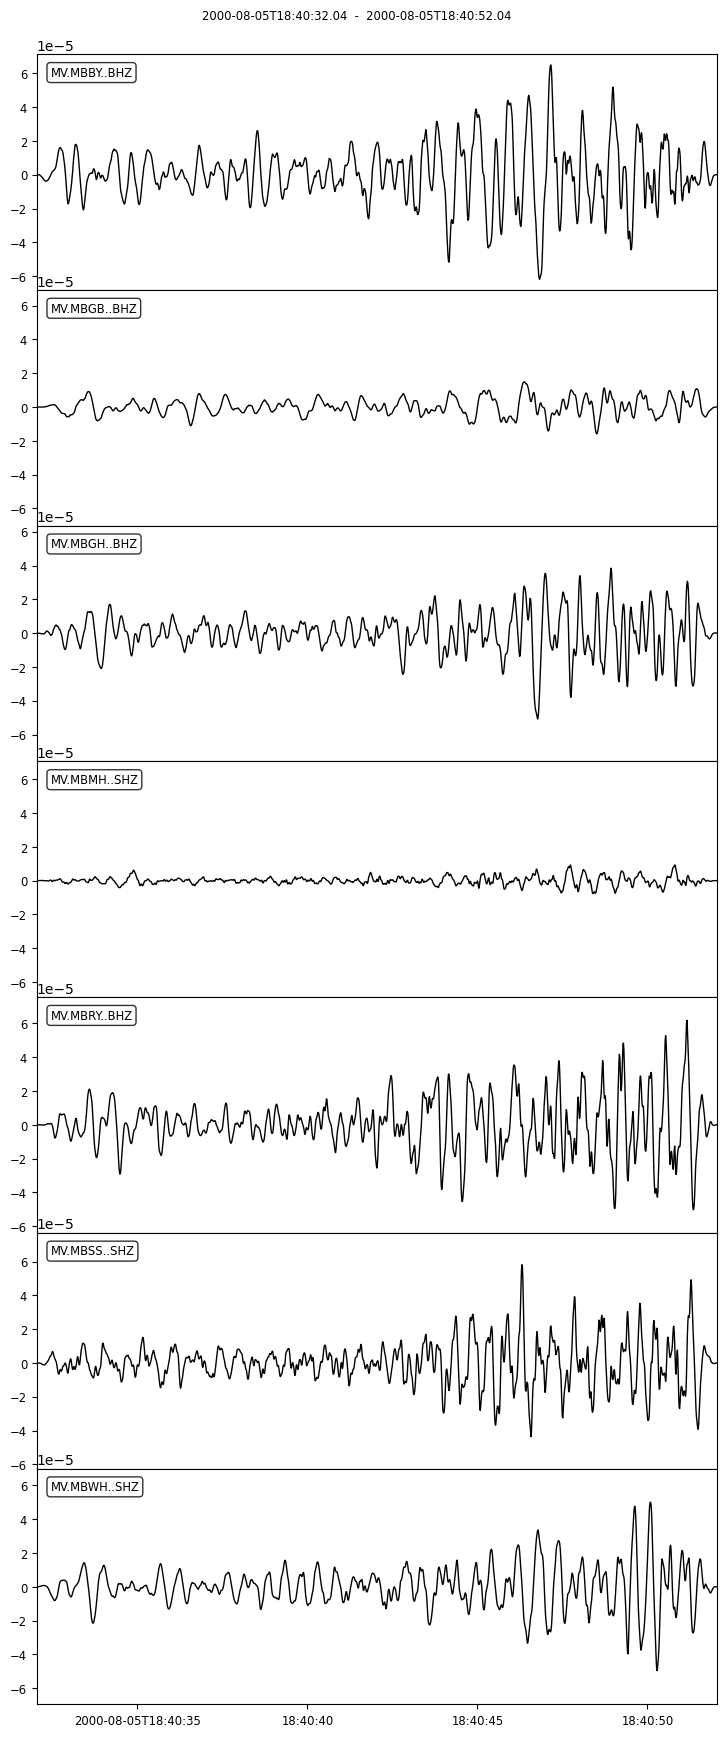

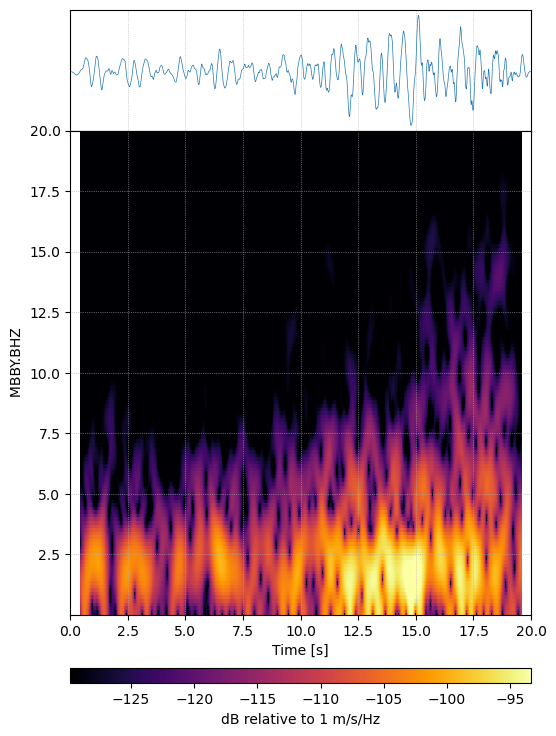

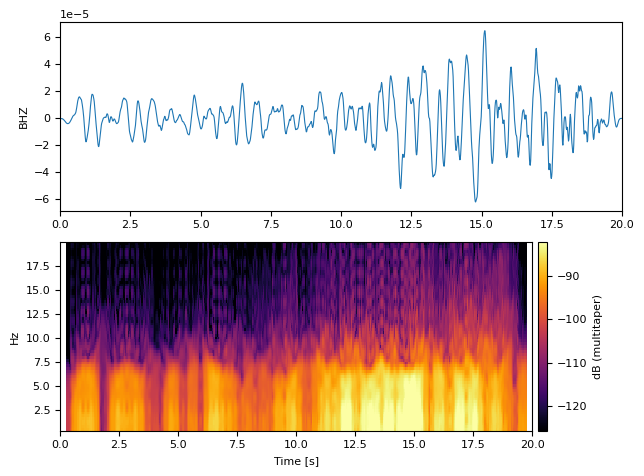

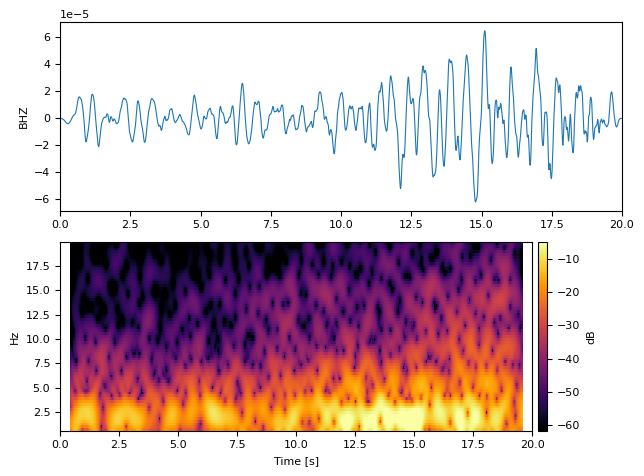

In [2]:
from obspy import read
st = read(best_event_files[0]).select(component='Z')
st.detrend('linear')
st.taper(0.05)
st.filter('bandpass', freqmin=0.5, freqmax=20.0, corners=4)
stime=st[0].stats.starttime+15
etime=stime+20
st.trim(starttime=stime, endtime=etime)
st.detrend('linear')
st.taper(0.05)
st.plot()

from flovopy.processing.spectrograms import plot_strongest_trace_multitaper, plot_strongest_trace, plot_strongest_trace_reassigned
plot_strongest_trace(st, log=False, dbscale=True, cmap='inferno', fmin=0.01, fmax=20.0)


plot_strongest_trace_multitaper(
    st, fs=100.0, fmin=0.1, fmax=20.0,
    overlap=0.875, NW=2.5,
    weighting="adaptive", nperseg_sec=0.48,
    #outfile="spectrogram_VEL.png"
)

plot_strongest_trace_reassigned(
    st,               # your trimmed Stream
    fmin=0.5, fmax=20.0,
    win_sec=0.64,     # try 0.48–0.80 s
    hop_frac=0.01,    # very dense hop
    pad_factor=4,
    cmap="inferno",
)

In [3]:
import os
print(os.getcwd())

/Users/glennthompson/Developer/flovopy/flovopy/tutorials
